In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import bayes3d as b
import time
from PIL import Image
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import cv2
import trimesh
import os

# Can be helpful for debugging:
# jax.config.update('jax_enable_checks', True) 



In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7013/static/


In [11]:
camera_pose = b.t3d.transform_from_pos_target_up(
    jnp.array([0.0, 1.5, 1.5]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
)

camera_poses = jnp.array([
    b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle) @ camera_pose
    for angle in jnp.linspace(0, 2*jnp.pi, 120)]
)

poses = jnp.linalg.inv(camera_poses)

translation_deltas = b.utils.make_translation_grid_enumeration(-0.2, -0.2, -0.2, 0.2, 0.2, 0.2, 11, 11, 11)
rotation_deltas = jax.vmap(lambda key: b.distributions.gaussian_vmf_zero_mean(key, 0.00001, 800.0))(
    jax.random.split(jax.random.PRNGKey(3), 500)
)

likelihood = jax.vmap(b.threedp3_likelihood_old, in_axes=(None, 0, None, None, None, None, None))

def update_pose_estimate(pose_estimate, gt_image):
    proposals = jnp.einsum("ij,ajk->aik", pose_estimate, translation_deltas)
    rendered_images = jax.vmap(b.RENDERER.render, in_axes=(0, None))(proposals[:,None, ...], jnp.array([0]))
    weights_new = likelihood(gt_image, rendered_images, 0.05, 0.1, 10**3, 0.1, 3)
    pose_estimate = proposals[jnp.argmax(weights_new)]

    proposals = jnp.einsum("ij,ajk->aik", pose_estimate, rotation_deltas)
    rendered_images = jax.vmap(b.RENDERER.render, in_axes=(0, None))(proposals[:, None, ...], jnp.array([0]))
    weights_new = likelihood(gt_image, rendered_images, 0.05, 0.1, 10**3, 0.1, 3)
    pose_estimate = proposals[jnp.argmax(weights_new)]
    return pose_estimate, pose_estimate

inference_program = jax.jit(lambda p,x: jax.lax.scan(update_pose_estimate, p,x)[1])

original_intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=150.0, fy=150.0,
    cx=100.0, cy=100.0,
    near=0.001, far=6.0
)

In [12]:
# input_viz_images = [b.get_depth_image(i[:,:,2]) for i in observed_images]
# b.make_gif_from_pil_images(input_viz_images, "input.gif")

In [13]:
b.utils.ycb_loader.MODEL_NAMES

['002_master_chef_can',
 '003_cracker_box',
 '004_sugar_box',
 '005_tomato_soup_can',
 '006_mustard_bottle',
 '007_tuna_fish_can',
 '008_pudding_box',
 '009_gelatin_box',
 '010_potted_meat_can',
 '011_banana',
 '019_pitcher_base',
 '021_bleach_cleanser',
 '024_bowl',
 '025_mug',
 '035_power_drill',
 '036_wood_block',
 '037_scissors',
 '040_large_marker',
 '051_large_clamp',
 '052_extra_large_clamp',
 '061_foam_brick']

In [14]:
scaling_factors = [1.0, 0.5, 0.25, 0.125]
object_ids = [19]
data = []

In [15]:
for OBJECT_ID_IDX in range(len(object_ids)):
    print(OBJECT_ID_IDX)
    dataa = []
    for SCALING_FACTOR_IDX in range(len(scaling_factors)):
        print(SCALING_FACTOR_IDX)
        intrinsics = b.scale_camera_parameters(original_intrinsics, scaling_factors[SCALING_FACTOR_IDX])
        
        b.setup_renderer(intrinsics)
        model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
        mesh_path = os.path.join(model_dir,"obj_" + "{}".format(object_ids[OBJECT_ID_IDX] + 1).rjust(6, '0') + ".ply")
        b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/100.0)
        
        observed_images = b.RENDERER.render_many(poses[:,None,...],  jnp.array([0]))
        print("observed_images.shape", observed_images.shape)
        
        inferred_poses = inference_program(poses[0], observed_images)
        
        start = time.time()
        pose_estimates_over_time = inference_program(poses[0], observed_images)
        end = time.time()
        print ("Time elapsed:", end - start)
        fps =  poses.shape[0] / (end - start)
        print ("FPS:", poses.shape[0] / (end - start))
        dataa.append((scaling_factors[SCALING_FACTOR_IDX], object_ids[OBJECT_ID_IDX], intrinsics.height, fps, pose_estimates_over_time))
        
        max_depth = 10.0
        rerendered_images = b.RENDERER.render_many(pose_estimates_over_time[:, None, ...], jnp.array([0]))
        viz_images = []
        for (r, d) in zip(rerendered_images, observed_images):
            viz_r = b.viz.scale_image(b.viz.get_depth_image(r[:,:,2]), 5.0)
            viz_d = b.viz.scale_image(b.viz.get_depth_image(d[:,:,2]), 5.0)
            overlay = b.viz.overlay_image(viz_r,viz_d)
            viz_images.append(b.viz.multi_panel(
                [
                    viz_d, viz_r, overlay
                ],
                ["Ground Truth", "Inferred Reconstruction", "Overlay"],
            ))

        b.make_gif_from_pil_images(viz_images, "demo.gif")
    data.append(dataa)

0
0
Increasing frame buffer size to (width, height, depth) = (224, 224, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


observed_images.shape (120, 200, 200, 4)
Time elapsed: 8.415842771530151
FPS: 14.258821517667426
1
Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)
observed_images.shape (120, 100, 100, 4)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Time elapsed: 3.2040841579437256
FPS: 37.45219978148514
2
Increasing frame buffer size to (width, height, depth) = (64, 64, 1024)
observed_images.shape (120, 50, 50, 4)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Time elapsed: 1.4280850887298584
FPS: 84.0286065214281
3
Increasing frame buffer size to (width, height, depth) = (32, 32, 1024)
observed_images.shape (120, 25, 25, 4)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Time elapsed: 1.151749849319458
FPS: 104.18929081771114


In [16]:
from scipy.spatial.transform import Rotation as R

In [17]:
def error_between_poses(pose_1, pose_2):
    translation_error = jnp.linalg.norm(pose_1[:3,3] - pose_2[:3,3])
    error_rotvec = R.from_matrix((pose_1 @ jnp.linalg.inv(pose_2))[:3,:3]).as_rotvec()
    rotation_error = jnp.rad2deg(jnp.linalg.norm(error_rotvec))
    return translation_error, rotation_error

In [18]:
output_string = ""
for OBJECT_ID_IDX in range(len(object_ids)):
    for SCALING_FACTOR_IDX in range(len(scaling_factors)-1,-1,-1):
        scaling_factor, object_id, resolution, fps, poses_inferred = data[OBJECT_ID_IDX][SCALING_FACTOR_IDX]
        errors = jnp.array([error_between_poses(p,t) for (p,t) in zip(poses_inferred, poses)])
        print(object_id, " & ",  resolution, " & ",f"{fps:0.3f}", " & ", f"{(float(errors[:,0].mean() * 10.0)):0.3f}", " & ", f"{(float(errors[:,1].mean() * 1.0)):0.3f}", "\\\\")

19  &  25  &  104.189  &  0.650  &  3.710 \\
19  &  50  &  84.029  &  0.392  &  1.980 \\
19  &  100  &  37.452  &  0.240  &  1.157 \\
19  &  200  &  14.259  &  0.254  &  1.281 \\


In [151]:

observed_images = b.RENDERER.render_many(poses[:,None,...],  jnp.array([0]))
print("observed_images.shape", observed_images.shape)

inferred_poses = inference_program(poses[0], observed_images)

start = time.time()
pose_estimates_over_time = inference_program(poses[0], observed_images)
end = time.time()
print ("Time elapsed:", end - start)
print ("FPS:", poses.shape[0] / (end - start))


observed_images.shape (120, 50, 50, 4)
Time elapsed: 1.4395387172698975
FPS: 83.36003648973156


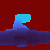

In [152]:
b.get_depth_image(observed_images[0][:,:,2])